# Simulating a Double Pendulum with Lagrangian Mechanics

Let's simulate in a vaccum for now



Determine lagrangian. Lagrangian is defined by difference between Kinetic energy ($T$) and Potential energy ($V$). Loosely, the lagrangian defines the state of the energy in the system (either completely positive for all kinetic energy or completely negative for all potential energy)

$$
L = T - V
$$

Euler-Lagrange equation:

$$
\frac{\partial L}{\partial q_i} = \frac{d}{dt} \left( \frac{\partial L}{\partial \dot{q_i}} \right)
$$

Where $q_i$ are the generalized coordinates of the system, which in our case are $\theta_1$ and $\theta_2$

What we'll do first is construct the lagrangian formula based on the $x_1$, $y_1$, $x_2$, and $y_2$ coordinates respectively, defined in the diagram above. And then substitute these coordinates with their representation in $\theta$ coordinates.

Since the equations can get unruly, we will get some help from the `sympy` library to construct and solve our equations

In [177]:
import sympy as sp
import numpy as np
import matplotlib.pyplot as plt
sp.init_printing()
import sympy.physics.mechanics as spm
spm.init_vprinting()


def equation(symbol, output):
    """
    Helper function for displaying equations
    """
    return display(sp.Eq(sp.S(symbol), output))

First we derive our equations using our $x$ and $y$ coordinates.

In [113]:
g, m1, L1, m2, L2 = sp.symbols('g m_1 L_1 m_2 L_2')              # Constants
x1, x2, y1, y2 = spm.dynamicsymbols('x_1 x_2 y_1 y_2')           # X,Y Coordinates
x1d, x2d, y1d, y2d = tuple( s.diff() for s in (x1, x2, y1, y2) ) # X,Y Derivatives

Our potential energy formula is related to the height $h$ of each mass.

$$
V = gm_1 h_1 + gm_2 h_2
$$

$h_1$ can be calculated from $y_1$, according to the graphic. $y_1$ is measured from the top down, with the minimum being $0$ and the maximum being $L_1$. All in all, $h_1$ can be defined as $L_1 - y_1$.

We might do something similar for $h_2$. However, in this case, the height of the second mass is also dependent on the height of the first, since they're both connected. So, we'll need to sum both contributions for our $h_2$ equation, giving $L_1 - y_1 + L_2 - y_2$. Our final potential energy equation becomes:

$$
V = g m_1 (L_1 - y_1) + g m_2 (L_1 - y_1 + L_2 - y_2)
$$

We can rearrange this to make things better for us (and `sympy`), by rearranging the equation in terms of $L_1 - y_1$ and $L_2 - y_2$

$$
V = g (m_1 + m_2) (L_1 - y_1) + g m_2 (L_2 - y_2)
$$

We can read this as the first height adds to the potential energy of both masses in the system, since it's lifting both masses by the same height.

In [114]:
# Potential Energy Formula
V = (m1 + m2)*g*(L1 - y1) + m2*g*(L2 - y2)
equation('V', V)

Next our kinetic energy formula

In [115]:
# Kinetic Energy Formula
half = sp.Rational(1,2)
T = half*m1*(x1.diff()**2 + y1.diff()**2) + half*m2*((x1.diff() + x2.diff())**2 + (y1.diff() + y2.diff())**2)
equation('T', T)

Finally, putting both these equations in the Lagrangian gives us the following

In [116]:
# Lagrangian Formula
L = T - V
equation('L', L)

Next we substitute our coordinates with $\theta_1$ and $\theta_2$ using conversion formulas

In [117]:
th1, th2 = spm.dynamicsymbols('\\theta_1 \\theta_2') # Theta coordiates

# Substitution
Lth = L.subs({
    x1: L1*sp.cos(th1),
    x2: L2*sp.cos(th2),
    y1: L1*sp.sin(th1),
    y2: L2*sp.sin(th2)
})
equation('L', Lth)

                                                                             ⎛                     2                        2⎞      ⎛                                           2                               
                                                                             ⎜⎛∂                  ⎞    ⎛∂                  ⎞ ⎟      ⎜⎛∂                     ∂                  ⎞    ⎛∂                     ∂    
                                                                          m₁⋅⎜⎜──(L₁⋅sin(\theta₁))⎟  + ⎜──(L₁⋅cos(\theta₁))⎟ ⎟   m₂⋅⎜⎜──(L₁⋅sin(\theta₁)) + ──(L₂⋅sin(\theta₂))⎟  + ⎜──(L₁⋅cos(\theta₁)) + ──(L₂
                                                                             ⎝⎝∂t                 ⎠    ⎝∂t                 ⎠ ⎠      ⎝⎝∂t                    ∂t                 ⎠    ⎝∂t                    ∂t   
L = -g⋅m₂⋅(-L₂⋅sin(\theta₂) + L₂) - g⋅(m₁ + m₂)⋅(-L₁⋅sin(\theta₁) + L₁) + ──────────────────────────────────────────────────── + ───────────────────────────────────

Finally, we can use trig identities to simplify a whole lot of this

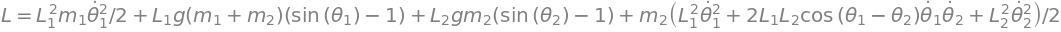

In [118]:
Lth = Lth.simplify().trigsimp()
equation('L', Lth)

Now we construct our differential equations

In [134]:
Eq1 = sp.Eq(Lth.diff(th1.diff()).diff(t), Lth.diff(th1) ).simplify()
Eq2 = sp.Eq(Lth.diff(th2.diff()).diff(t), Lth.diff(th2) ).simplify()
display(Eq1)
display(Eq2)

And finally, solve for $\ddot{\theta}$

In [168]:
th1dd = th1.diff(t,t)
th2dd = th2.diff(t,t)
Thdd = sp.solve([Eq1, Eq2], [th1dd, th2dd], dict=True)[0]

Let's see if these monster equations work...

In [ ]:
# Input equations
Thdd1R = Thdd1.subs({ m1: 1, m2: 1, L1: 1, L2: 1, g:9.81 })
Thdd2R = Thdd2.subs({ m1: 1, m2: 1, L1: 1, L2: 1, g:9.81 })

# Manually solving
steps = 1000
dT = 0.01
vTh1 = 0.5*np.pi
vTh2 = 0.35*np.pi
vThd1 = 0
vThd2 = 0
sTh = []
for i in range(steps):
    sTh.append([vTh1, vTh2])
    vTh1 += dT*vThd1
    vTh2 += dT*vThd2
    vThd1 += dT*Thdd1R.subs({ th1:vTh1, th2:vTh2, th1.diff():vThd1, th2.diff():vThd2 })
    vThd2 += dT*Thdd2R.subs({ th1:vTh1, th2:vTh2, th1.diff():vThd1, th2.diff():vThd2 })
sTh = np.array(sTh, dtype=float)